In [88]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from xgboost import XGBRegressor
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

In [165]:
data = pd.read_csv('original_datasets/csiro_recons_gmsl_mo.csv', delimiter=',')

In [166]:
data.head().append(data.tail())

,Time,GMSL,GMSL uncertainty
0,1880-01-15,-183.0,24.2
1,1880-02-15,-171.1,24.2
2,1880-03-15,-164.3,24.2
3,1880-04-15,-158.2,24.2
4,1880-05-15,-158.7,24.2
1603,2013-08-15,71.6,8.8
1604,2013-09-15,68.8,8.8
1605,2013-10-15,66.4,8.9
1606,2013-11-15,59.7,9.0
1607,2013-12-15,58.5,9.0


In [167]:
data['Time'] = pd.to_datetime(data['Time'], format='%Y-%m-%d %H:%M:%S')
data['Time'] = data['Time'].dt.strftime('%Y-%m')
data['Time'] = pd.to_datetime(data['Time'], format='%Y-%m-%d %H:%M:%S')
data = data.set_index('Time')
data = data.asfreq('MS')
data = data.sort_index()
data


,GMSL,GMSL uncertainty
Time,,
1880-01-01,-183.0,24.2
1880-02-01,-171.1,24.2
1880-03-01,-164.3,24.2
1880-04-01,-158.2,24.2
1880-05-01,-158.7,24.2
...,...,...
2013-08-01,71.6,8.8
2013-09-01,68.8,8.8
2013-10-01,66.4,8.9


In [168]:
# Split train-val-test
# ==============================================================================
end_train = '1980-12-01'
end_validation = '2000-12-01'
data_train = data.loc[: end_train, :]
data_val   = data.loc[end_train:end_validation, :]
data_test  = data.loc[end_validation:, :]

print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates validacion : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train      : 1880-01-01 00:00:00 --- 1980-12-01 00:00:00  (n=1212)
Dates validacion : 1980-12-01 00:00:00 --- 2000-12-01 00:00:00  (n=241)
Dates test       : 2000-12-01 00:00:00 --- 2013-12-01 00:00:00  (n=157)


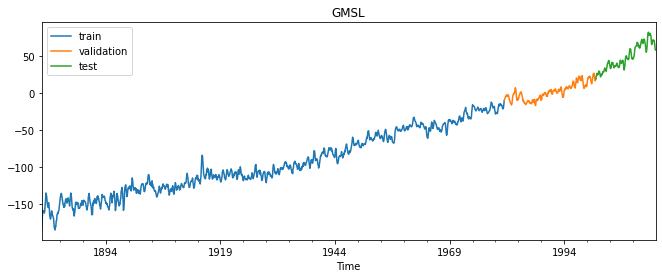

In [169]:
fig, ax = plt.subplots(figsize=(11, 4))
data_train['GMSL'].plot(ax=ax, label='train')
data_val['GMSL'].plot(ax=ax, label='validation')
data_test['GMSL'].plot(ax=ax, label='test')
ax.set_title('GMSL')
ax.legend()

In [170]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=123),
                lags = 8
             )

In [171]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters
param_grid = {
    'n_estimators': [50, 100, 500],
    'max_depth': [3, 5, 6, 10, 15],
    'learning_rate': [0.01, 0.1]
}

# Lags used as predictors
lags_grid = [72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]
#lags_grid = [3, 10, [1, 2, 3, 20]]

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data.loc[:end_validation, 'GMSL'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = 12,
                        refit              = False,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)),
                        return_best        = True,
                        verbose            = False
                   )

Number of models compared: 60


loop lags_grid: 100%|██████████████████████████████████████| 2/2 [03:56<00:00, 118.49s/it]


Refitting `forecaster` using the best found parameters and the whole data set: 
  lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  params: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50}



In [172]:
# Backtesting
# ==============================================================================
metric, predictions = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = data['GMSL'],
    initial_train_size = len(data.loc[:end_validation]),
    steps              = 12,
    refit              = False,
    metric             = 'mean_squared_error',
    verbose            = False
)

print(f"Backtest error: {metric}")

Backtest error: [2378.19852051]


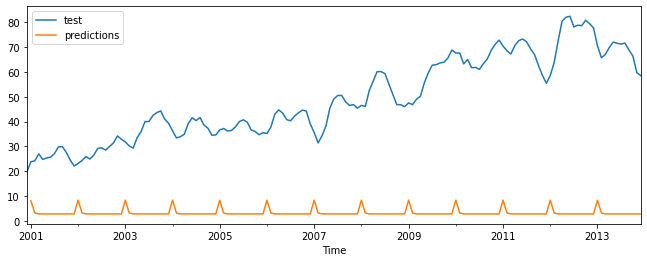

In [173]:
# Plot of predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4))
data_test['GMSL'].plot(ax=ax, label='test')
predictions['pred'].plot(ax=ax, label='predictions')
ax.legend();